In [1]:
#Import Relevant Libraries
import pandas as pd 
import numpy as np
import statsmodels.api as sm 
import matplotlib.pyplot as plt 
import statistics
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn import metrics
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import seaborn as sns 
sns.set() 
from sklearn.cluster import KMeans 
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt 
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from numpy import unique
from minisom import MiniSom
import plotly.express as px

In [2]:
#Read the excel file
data = pd.read_csv('Online Retail.csv')
print('\n Dimension of Data is : ')
print(data.shape)


 Dimension of Data is : 
(541909, 8)


## Data Cleaning and Preprocessing Steps

1. **Check for Missing Values**  
   Identified missing values in each column using `isnull().sum()`.

2. **Handle Missing `CustomerID`**  
   Replaced blank strings in `CustomerID` with `NaN` and removed those rows.

3. **Remove Duplicate Records**  
   Dropped any duplicate rows to ensure data integrity.

4. **Compute `TotalPrice`**  
   Created a new column `TotalPrice` as the product of `Quantity` and `UnitPrice`.

5. **Aggregate by Invoice**  
   - Calculated the number of records per invoice (`InvoiceCounts`).
   - Calculated total price per invoice (`InvoicePrice`).
   - Combined both metrics into a summary DataFrame.


In [3]:
#Check for Missing Values
print('\n Missing data : ')
print(data.isnull().sum())

#Removing Records having Blank values in CustomerID
data['CustomerID'].replace('', np.nan, inplace=True)
data.dropna(subset=['CustomerID'], inplace=True)

#Removing Records having Blank values in CustomerID
data['CustomerID'].replace('', np.nan, inplace=True)
data.dropna(subset=['CustomerID'], inplace=True)

#Drop Duplicate Records
data.drop_duplicates()

#Calculate TotalPrice
data['TotalPrice']=data['Quantity']*data['UnitPrice']

#Aggregate
df = data.groupby(['InvoiceNo'])['InvoiceNo'].count().reset_index(name='InvoiceCounts')
df1 = data.groupby(['InvoiceNo'])['TotalPrice'].sum().reset_index(name='InvoicePrice')
df=df.join(df1['InvoicePrice'])


 Missing data : 
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [8]:
#View the statistical summary of numerical variables
print('Summary Statistics is :')
df[['InvoiceCounts','InvoicePrice']].describe()

Summary Statistics is :


,InvoiceCounts,InvoicePrice
count,22190.000000,22190.000000
mean,18.333889,374.045327
std,23.892111,2018.482869
min,1.000000,-168469.600000
25%,3.000000,87.962500
50%,12.000000,241.505000
75%,24.000000,418.022500
max,542.000000,168469.600000


## RFM (Recency, Frequency, Monetary) Analysis

1. **Recency Calculation**  
   - Computed the last purchase date per customer.
   - Calculated `Recency` as the number of days since their last purchase.

2. **Frequency Calculation**  
   - Counted the number of unique transactions (`InvoiceDate`) per customer to get `Frequency`.

3. **Monetary Value Calculation**  
   - Calculated total monetary value per customer (`UnitPrice × Quantity`).

4. **Merged RFM Data**  
   - Combined Recency, Frequency, and Monetary metrics into a single `rfm_data` DataFrame.

5. **RFM Ranking**  
   - Ranked customers for each metric (Recency, Frequency, Monetary).
   - Normalized each rank on a 0–100 scale.

6. **RFM Score Calculation**  
   - Computed a weighted `RFM_Score`:
     - 15% Recency
     - 28% Frequency
     - 57% Monetary
   - Final score was scaled and rounded.

7. **Customer Segmentation**  
   - Segmented customers into 5 groups:
     - Top Customers
     - High Value Customers
     - Medium Value Customers
     - Low Value Customers
     - Lost Customers

8. **Segment Visualization**  
   - Displayed a pie chart showing distribution of customer segments.


In [9]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

#RFM Analysis

#Calculating Recency
data_recency = data.groupby(by='CustomerID',
                        as_index=False)['InvoiceDate'].max()
data_recency.columns = ['CustomerID', 'LastInvoiceDate']
recent_date = data_recency['LastInvoiceDate'].max()
data_recency['Recency'] = data_recency['LastInvoiceDate'].apply(
    lambda x: (recent_date - x).days)
print(data_recency.head(5))

#Calculating Frequency
frequency_data = data.drop_duplicates().groupby(
    by=['CustomerID'], as_index=False)['InvoiceDate'].count()
frequency_data.columns = ['CustomerID', 'Frequency']
frequency_data.head(5)

#Calculating Monetary Value
data['Total'] = data['UnitPrice']*data['Quantity']
monetary_data = data.groupby(by='CustomerID', as_index=False)['Total'].sum()
monetary_data.columns = ['CustomerID', 'Monetary']
monetary_data.head(5)

#Merging RFM
rf_data = data_recency.merge(frequency_data, on='CustomerID')
rfm_data = rf_data.merge(monetary_data, on='CustomerID').drop(
    columns='LastInvoiceDate')
rfm_data.head(5)

#Ranking Customer’s based upon their RFM score
rfm_data['R_rank'] = rfm_data['Recency'].rank(ascending=False)
rfm_data['F_rank'] = rfm_data['Frequency'].rank(ascending=True)
rfm_data['M_rank'] = rfm_data['Monetary'].rank(ascending=True)
 
# normalizing the rank of the customers
rfm_data['R_rank_norm'] = (rfm_data['R_rank']/rfm_data['R_rank'].max())*100
rfm_data['F_rank_norm'] = (rfm_data['F_rank']/rfm_data['F_rank'].max())*100
rfm_data['M_rank_norm'] = (rfm_data['F_rank']/rfm_data['M_rank'].max())*100
 
rfm_data.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
rfm_data.head(5)

#Calculating RFM score
rfm_data['RFM_Score'] = 0.15*rfm_data['R_rank_norm']+0.28 * \
    rfm_data['F_rank_norm']+0.57*rfm_data['M_rank_norm']
rfm_data['RFM_Score'] *= 0.05
rfm_data = rfm_data.round(2)
rfm_data[['CustomerID', 'RFM_Score']].head(5)

#Rating Customer based upon the RFM score
rfm_data["Customer_segment"] = np.where(rfm_data['RFM_Score'] >
                                      4.5, "Top Customers",
                                      (np.where(
                                        rfm_data['RFM_Score'] > 4,
                                        "High value Customer",
                                        (np.where(
    rfm_data['RFM_Score'] > 3,
                             "Medium Value Customer",
                             np.where(rfm_data['RFM_Score'] > 1.6,
                            'Low Value Customers', 'Lost Customers'))))))
rfm_data['CustomerID'] = rfm_data['CustomerID'].astype(int)
rfm_data[['CustomerID', 'RFM_Score', 'Customer_segment']].head(20)

   CustomerID     LastInvoiceDate  Recency
0     12346.0 2011-01-18 10:17:00      325
1     12347.0 2011-12-07 15:52:00        1
2     12348.0 2011-09-25 13:13:00       74
3     12349.0 2011-11-21 09:51:00       18
4     12350.0 2011-02-02 16:01:00      309


,CustomerID,RFM_Score,Customer_segment
0,12346,0.13,Lost Customers
1,12347,4.48,High value Customer
2,12348,2.07,Low Value Customers
3,12349,3.38,Medium Value Customer
4,12350,1.10,Lost Customers
5,12352,3.56,Medium Value Customer
6,12353,0.34,Lost Customers
7,12354,2.66,Low Value Customers
8,12355,0.93,Lost Customers
9,12356,3.09,Medium Value Customer


In [10]:
print(rfm_data['Customer_segment'].value_counts())
print(rfm_data['Customer_segment'].value_counts(normalize=True))


Customer_segment
Lost Customers           1339
Low Value Customers      1335
Medium Value Customer     927
High value Customer       433
Top Customers             338
Name: count, dtype: int64
Customer_segment
Lost Customers           0.306267
Low Value Customers      0.305352
Medium Value Customer    0.212031
High value Customer      0.099039
Top Customers            0.077310
Name: proportion, dtype: float64


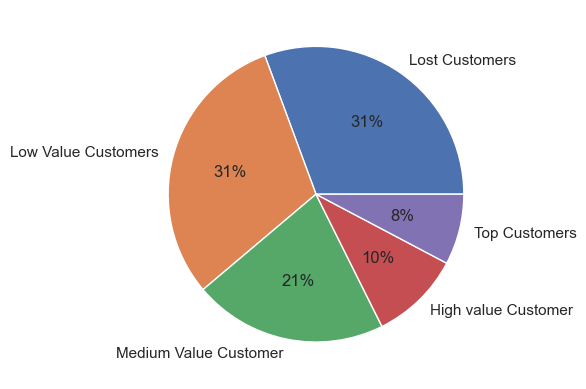

In [11]:
#Visualizing the customer segments
plt.pie(rfm_data.Customer_segment.value_counts(),
        labels=rfm_data.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()

## Preparing Data for Visualizing

1. **Feature and Target Selection**  
   - Selected `InvoiceCounts` as the feature (`X`) and `InvoicePrice` as the target (`y`).

2. **Train-Test Split**  
   - Split the data into 80% training and 20% testing sets using `train_test_split`.

3. **Data Visualization**  
   - Plotted scatter plots for:
     - Training set (`InvoiceCounts` vs `InvoicePrice`)
     - Testing set (`InvoiceCounts` vs `InvoicePrice`)  
   - Helps visualize the relationship and data distribution.


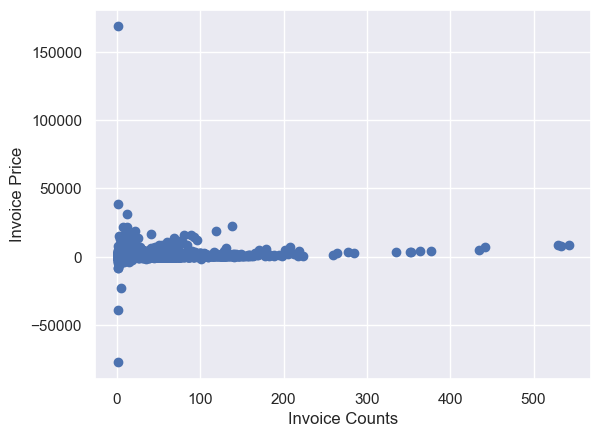

In [12]:
#Declare feature vector and target variable
X = df['InvoiceCounts']
y= df['InvoicePrice']

#Split the data Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = 0.80)

#Plot of Train Data
plt.scatter(X_train, y_train)
plt.xlabel('Invoice Counts')
plt.ylabel('Invoice Price')
plt.show()

X = df.iloc[:,-2:].values

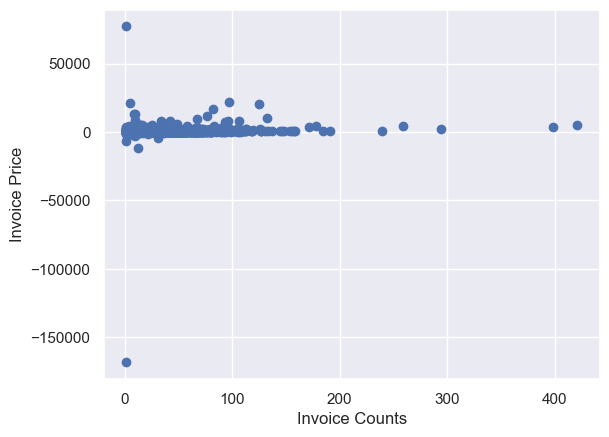

In [13]:
#Plot of Test Data
plt.scatter(X_test, y_test)
plt.xlabel('Invoice Counts')
plt.ylabel('Invoice Price')
plt.show()

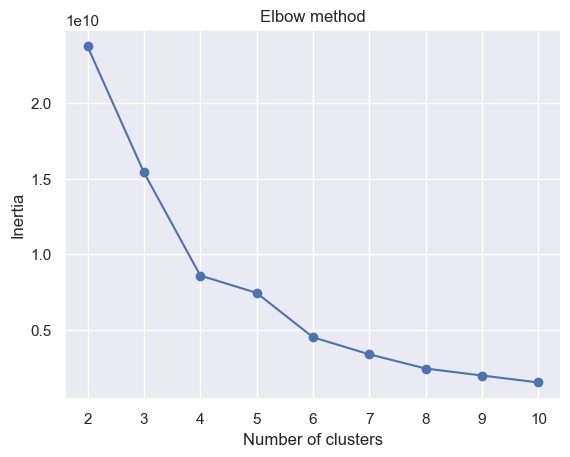

In [14]:
#Elbow method to visualize the intertia
data_train = list(zip(X_train, y_train))
data_test = list(zip(X_test, y_test))
inertias = []

for i in range(2,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data_train)
    inertias.append(kmeans.inertia_)

plt.plot(range(2,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

## Model Application: K-Means Clustering

1. **Elbow Method for Optimal Clusters**  
   - Plotted inertia values for `k = 2 to 10` to identify the optimal number of clusters using the Elbow method.

2. **Data Scaling (Min-Max Normalization)**  
   - Scaled both training and testing data to the range [0, 1] using `MinMaxScaler`.

3. **K-Means Clustering (k = 3)**  
   - Applied K-Means with 3 clusters on the scaled training data.
   - Displayed cluster centers and inertia value.
   - Visualized the clusters with a scatter plot.

4. **Silhouette Score**  
   - Calculated the Silhouette score to evaluate how well the data points fit within their clusters (higher is better).


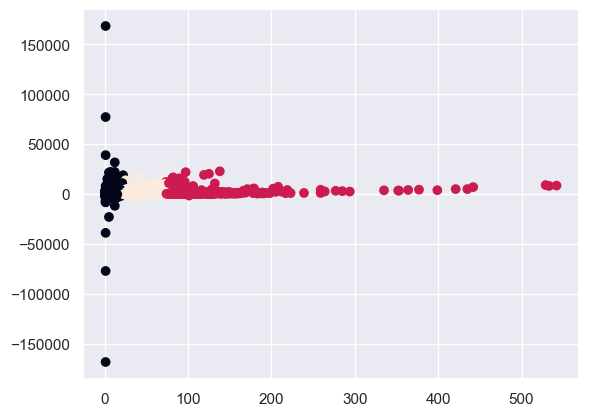

In [15]:
#K-Means model with three clusters
scaler = MinMaxScaler()
data_scaled_train = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(data_scaled_train)

plt.scatter(X[:,0], X[:,1], c=kmeans.labels_)
plt.show()

In [16]:
#Checking quality of classification by the K-Means model
labels = kmeans.labels_

#Evaluating performance of the clustering algorithm
#using a Silhouette score
print('\n The Silhouette score for K-Means is : ')
print(silhouette_score(data_scaled_train, kmeans.labels_, metric='euclidean'))



 The Silhouette score for K-Means is : 
0.6384335065864657


## Model Application: Gaussian Mixture Model (GMM)

1. **Data Standardization and Normalization**  
   - Standardized the training data using `StandardScaler`.
   - Normalized the data to unit vectors using `normalize()`.

2. **Dimensionality Reduction with PCA**  
   - Applied Principal Component Analysis (PCA) to reduce the data to 2 dimensions (`P1`, `P2`) for easier visualization.

3. **Gaussian Mixture Clustering**  
   - Fitted a GMM with 3 components to the reduced data.
   - Visualized the clustering result using a scatter plot.

4. **Silhouette Score**  
   - Evaluated clustering quality using Silhouette Score (ranges from -1 to 1; higher indicates better-defined clusters).


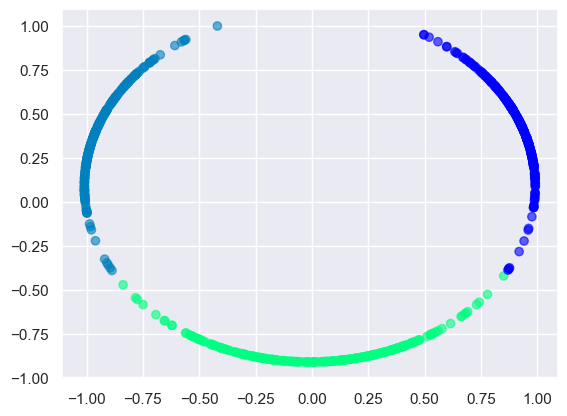

Silhouette Score: 0.7589049725922914


In [44]:
#Gaussian Mixture Model

# Standardize data
scaler = StandardScaler() 
scaled_df = scaler.fit_transform(data_train) 
  
# Normalizing the Data 
normalized_df = normalize(scaled_df) 
  
# Converting the numpy array into a pandas DataFrame 
normalized_df = pd.DataFrame(normalized_df) 
  
# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(normalized_df) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2'] 
X_principal.head(3)

gmm = GaussianMixture(n_components=3)
gmm.fit(X_principal)

#Visualizing the clustering of GaussianMixture
plt.scatter(X_principal['P1'], X_principal['P2'],  
           c = GaussianMixture(n_components = 3).fit_predict(X_principal), cmap =plt.cm.winter, alpha = 0.6) 
plt.show() 

# Checking quality of classification by the Gaussian Mixture model
labels = gmm.predict(X_principal)
correct_labels = sum(labels)
score = silhouette_score(X_principal, labels)
print("Silhouette Score:", score)

## Model Application: DBSCAN (Density-Based Spatial Clustering)

1. **Data Preparation**  
   - Generated synthetic blob data with 3 centers for clustering.
   - Standardized the data using `StandardScaler` for uniformity.

2. **Applying DBSCAN**  
   - Applied DBSCAN with `eps=0.3` and `min_samples=10`.
   - Created a mask to identify core samples.
   - Computed the number of clusters (excluding noise) and number of noise points.

3. **Evaluation Metrics**  
   - Reported clustering evaluation metrics:
     - **Silhouette Coefficient**: evaluates cohesion and separation; > 0.5 indicates well-separated clusters.

4. **Visualization**  
   - Plotted clusters with different colors, marking noise points in black.
   - Cluster shapes and densities are highlighted visually.


In [18]:
#DBSCAN Clustering Model (Distribution Based)

#create a ‘Cluster’ column
# Generate sample data
centers = [[1, 1], [-1, -1], [1, -1]]
data_train, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=0)
X = StandardScaler().fit_transform(data_train)

#Computing DB_SCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

#Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

#Evaluation of DB_SCAN
#Silhouette Coefficient score of more than 0.5 indicating that my model # doesn’t have overlapping clusters or mislabeled data points.
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 3
Estimated number of noise points: 18
Silhouette Coefficient: 0.626


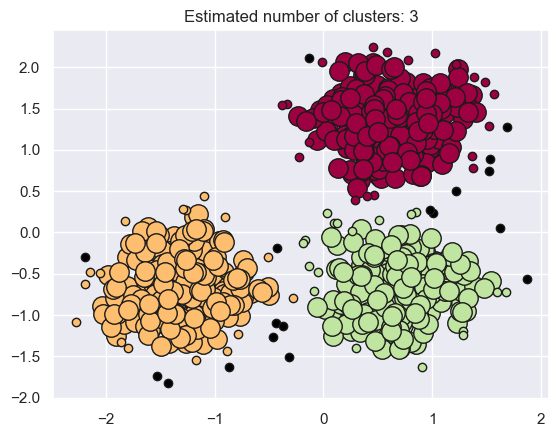

In [19]:
#Visualizing the clustering
# Plot result
import matplotlib.pyplot as plt
%matplotlib inline

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

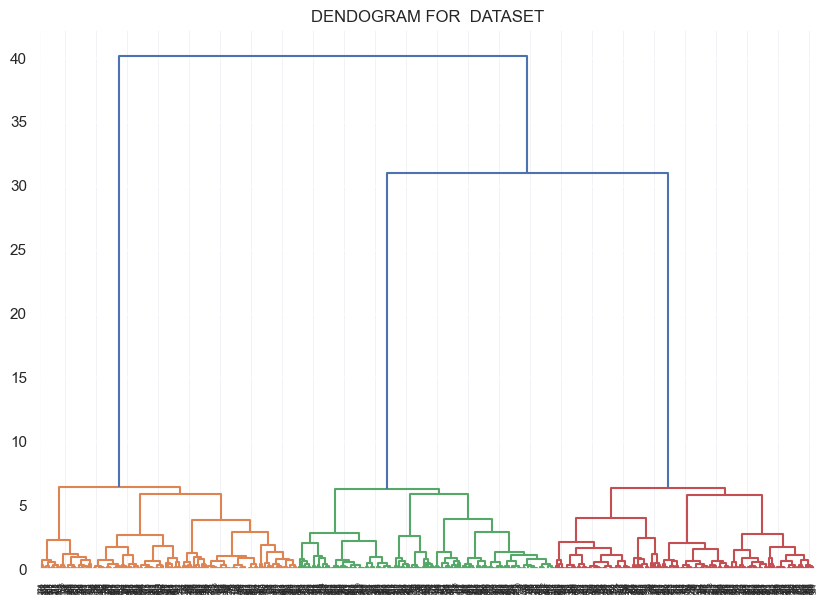

In [20]:
#Hierarchical Clustering
#Dendogram Construction
plt.figure(figsize=(10, 7))
plt.title("DENDOGRAM FOR  DATASET")
dendo_gram = shc.dendrogram(shc.linkage(X, method = "ward"))
plt.show() 

## Model Application: Agglomerative Clustering

1. **Clustering**  
   - Applied `AgglomerativeClustering` with 3 clusters, using:
     - **Euclidean distance** as the metric.
     - **Ward linkage** to minimize variance within clusters.

2. **Visualization**  
   - Plotted the resulting clusters using color to differentiate them.

3. **Evaluation**  
   - Computed the **Silhouette Score** to assess clustering quality.


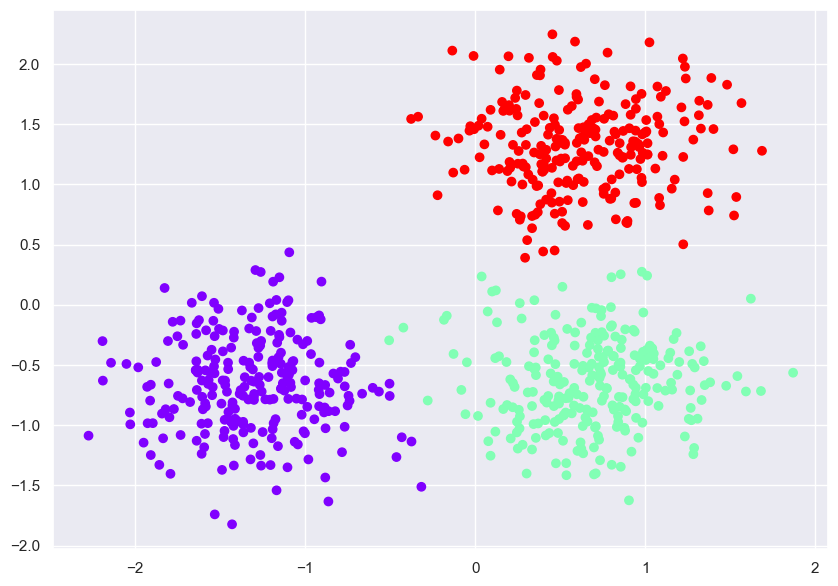

In [21]:
#Agglomerative Clustering
cluster = AgglomerativeClustering(n_clusters = 3, linkage = "ward")
cluster.fit_predict(X)
#Visualising the clusters
plt.figure(figsize=(10, 7))
plt.scatter(X[:,0], X[:,1], c=cluster.labels_, cmap='rainbow')
plt.show()

In [22]:
#Computing Agglomerative Score
print('Agglomerative Score is :')
print(silhouette_score(X,cluster.labels_, metric='euclidean'))

Agglomerative Score is :
0.6477977039854915


## Model Application: BIRCH (Balanced Iterative Reducing and Clustering using Hierarchies)

1. **Model Fitting**  
   - Applied `Birch` clustering with:
     - `threshold=0.01` to control cluster tightness.
     - `n_clusters=3` for final clustering.

2. **Cluster Information**  
   - Extracted unique cluster IDs assigned by BIRCH.
   - Plotted the clusters using a scatter plot with color-coded labels.

3. **Evaluation**  
   - Calculated the **Silhouette Score** to evaluate clustering performance.


Clusters of Birch [0 1 2]


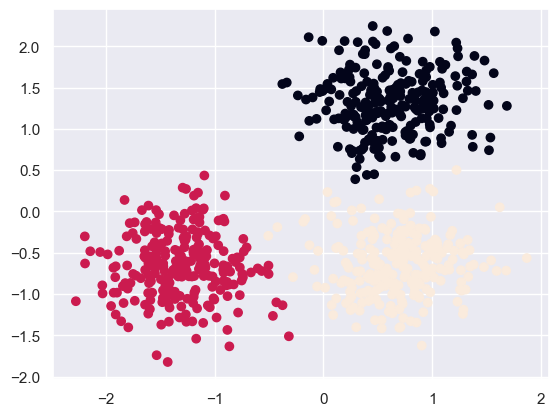

Score of Birch =  0.6472104406200997


In [23]:
#BIRCH Algorithm
model_br = Birch(threshold=0.01, n_clusters=3)
model_br.fit(X)
yhat_br = model_br.predict(X)
clusters_br = unique(yhat_br)
print("Clusters of Birch",clusters_br)
labels_br = model_br.labels_
plt.scatter(X[:, 0], X[:, 1], c = yhat_br)
score_br = metrics.silhouette_score(X,labels_br)
plt.show()
print("Score of Birch = ", score_br)

### Training and Visualizing a Self-Organizing Map (SOM)

This cell demonstrates the use of a Self-Organizing Map (SOM) to identify patterns in customer data. The steps are as follows:

- **Data Normalization:** 
    The InvoiceCounts and InvoicePrice columns are scaled using MinMaxScaler to bring all values into the range [0, 1], which is essential for              effective SOM training.

- **SOM Initialization:**  
    A 10×10 SOM grid is created using the MiniSom library. Each neuron in the grid is initialized to handle 2-dimensional input vectors.  
    Parameters:
  - sigma = 1.0: Defines the radius of the neighborhood function.
  - learning_rate = 0.5: Determines how much the weights are adjusted during training.

- **Training:**  
    The SOM is trained on the scaled data for 100 iterations. During training, the SOM adjusts its weights to organize similar input patterns into          nearby neurons. 

- **Visualization:**  
    A distance map (also known as a U-Matrix) is plotted using plt.imshow. The color intensity represents the distance between neighboring neurons:
  - Darker areas indicate similar neurons (dense clusters).
  - Lighter areas suggest greater differences (cluster boundaries).

    This visualization helps in interpreting the clustering structure formed by the SOM.

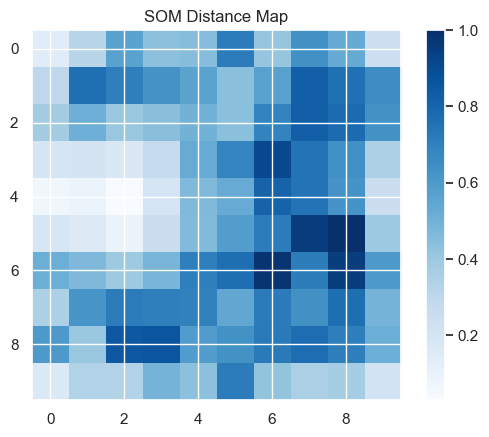

In [24]:

# Scale the data for SOM
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['InvoiceCounts', 'InvoicePrice']])

# Initialize and train SOM
som = MiniSom(x=10, y=10, input_len=2, sigma=1.0, learning_rate=0.5)
som.train(data_scaled_train, 100)

# Visualize SOM
plt.imshow(som.distance_map().T, cmap='Blues') 
plt.colorbar()
plt.title('SOM Distance Map')
plt.show()

### What You Can Conclude

- **Cluster boundaries are visible** where the darker blue squares appear:
  - These are likely **separators between distinct clusters** in your dataset.
  - For example, around coordinates **(4,8), (6,8), (8,2)**, etc., you see dark blocks → potential cluster edges.

- **Cluster centers or homogeneous areas** are in lighter regions:
  - The large **white/light blue area in the center (around [2:5, 2:6])** indicates a region of highly similar data points — likely a **large, coherent cluster**.

- **You can estimate the number of clusters** by counting the number of distinct light-blue "blobs" separated by dark areas.
  - **Rough estimate**: there might be **~3–5 clusters**, with one dominant cluster in the center.


### Autoencoder-Based Dimensionality Reduction and Clustering

This cell uses an autoencoder to reduce the dimensionality of the dataset and then applies clustering on the learned representations. The key steps are:

- **Autoencoder Architecture**:  
  A simple autoencoder is defined using the Keras functional API:
  - Input Layer: Matches the dimensionality of the scaled data.
  - Encoding Layer: A dense layer with 64 neurons and ReLU activation compresses the input.
  - Decoding Layer: Reconstructs the original input using a sigmoid-activated layer.

- **Model Compilation and Training**:  
  - Optimizer: adam  
  - Loss Function: Mean Squared Error (MSE)  
  The model is trained to reconstruct the input data over 30 epochs with a batch size of 256, using shuffling for better generalization.

- **Feature Extraction**:  
  After training, the encoder part of the network is isolated to obtain compressed representations (encoded_data) of the input.


In [25]:
data_scaled_train.shape

(22190, 2)

In [33]:
# Autoencoder for Clustering
from keras.layers import Input, Dense
from keras.models import Model

# Define Autoencoder
input_layer = Input(shape=(data_scaled_train.shape[1],))
encoded = Dense(64, activation='relu')(input_layer)
decoded = Dense(data_scaled_train.shape[1], activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Train Autoencoder
autoencoder.fit(data_scaled_train, data_scaled_train, epochs=30, batch_size=256, shuffle=True)

# Extract encoder part for dimensionality reduction
encoder = Model(input_layer, encoded)
encoded_data = encoder.predict(data_scaled_train)

Epoch 1/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0682
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016
Epoch 5/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013
Epoch 6/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011
Epoch 7/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.5202e-04
Epoch 8/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.8962e-04
Epoch 9/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.8714e-04
Epoch 10/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.5348e-04
Epoch 11/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2761e-04
Epoch 12/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5441e-04
Epoch 13/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.1774e-04
Epoch 14/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8557e-04
Epoch 15/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

## Clustering:  
  The reduced data is passed to the KMeans algorithm to identify clusters in the latent space.  
  - KMeans is configured to find 3 clusters with a fixed random seed for reproducibility.

This approach helps in discovering meaningful patterns in high-dimensional data by clustering in a compressed, feature-rich space.

In [42]:
# Use clustering on the encoded data (KMeans for example)
kmeans_autoencoder = KMeans(n_clusters=3, random_state=42)
autoencoder_labels = kmeans_autoencoder.fit_predict(encoded_data)

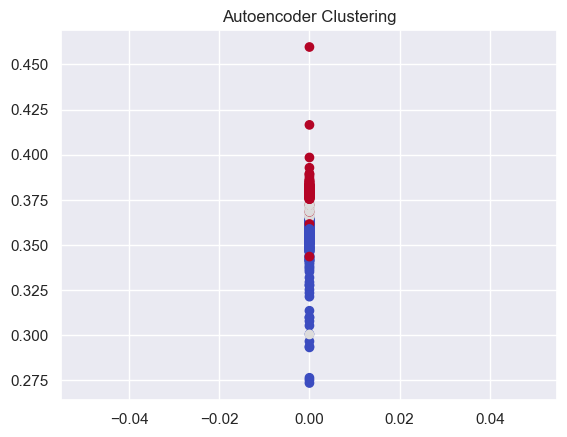

In [43]:
# Visualize clustering on encoded data
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=autoencoder_labels, cmap='coolwarm')
plt.title('Autoencoder Clustering')
plt.show()

In [36]:
# Calculate the Silhouette Score
sil_score = silhouette_score(encoded_data, autoencoder_labels, metric='euclidean')

# Print the Silhouette Score
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: 0.6483


 ### Gaussian Mixture Model (GMM) Clustering and Evaluation

   This cell performs clustering on the encoded data using a Gaussian Mixture Model and evaluates the clustering quality:

- **Gaussian Mixture Model (GMM):**  
    A GMM with 4 components is fit to the encoded feature space. Unlike KMeans, GMM uses a probabilistic model to estimate the likelihood of data           points belonging to each cluster, allowing more flexibility in cluster shapes.

- **Clustering Assignment:**  
    Cluster labels are predicted for each data point in the encoded space using fit_predict.

- **Silhouette Score:** 
    The clustering output is evaluated using the Silhouette Score:
    - Measures how well each point fits within its cluster compared to neighboring clusters.
    - Values close to 1 indicate well-separated clusters.
    - The final score is printed with four decimal places.

This provides a statistical validation of the clustering quality achieved using GMM.

In [37]:

# Apply Gaussian Mixture Model (GMM) to the encoded data
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(encoded_data)

# Silhouette Score for GMM
sil_score_gmm = silhouette_score(encoded_data, gmm_labels, metric='euclidean')

# Print the Silhouette Score for GMM
print(f"Silhouette Score for GMM: {sil_score_gmm:.4f}")


Silhouette Score for GMM: 0.6472


### DBSCAN Clustering on Encoded Data and Evaluation

This cell applies the DBSCAN algorithm to the encoded feature space and evaluates the clustering outcome:

- **DBSCAN Clustering**:  
    - Uses eps = 0.012 and min_samples = 5 to define neighborhood density.
    - Capable of identifying clusters of arbitrary shape and detecting noise points (assigned label -1).
- **Visualization**:  
    A scatter plot shows the clustering result using the first two encoded dimensions.
    - Different colors represent different clusters.
    - The tab10 colormap is used for clear categorical separation.
    - Noise points are colored distinctly.

- **Cluster Evaluation**:
    - The number of estimated clusters is computed, excluding noise points.
    - If at least two clusters are found:
    - Silhouette Score is calculated to measure clustering cohesion and separation.

    This approach evaluates the ability of DBSCAN to identify meaningful structure in the compressed representation while handling noise and outliers.


##  Finding the Optimal eps for DBSCAN using k-Distance Plot

To determine the best eps value for DBSCAN, we use a **k-distance plot**. This approach helps identify a natural distance threshold where clusters can be separated effectively.

###  Steps:
1. Set `k = min_samples - 1`.
2. For each point, calculate the distance to its **k-th nearest neighbor**.
3. Sort all these distances in ascending order.
4. Plot the sorted distances. The point of maximum curvature (elbow) indicates a suitable value for `eps`.

> Choosing an eps near the elbow balances between grouping dense clusters and ignoring sparse noise.

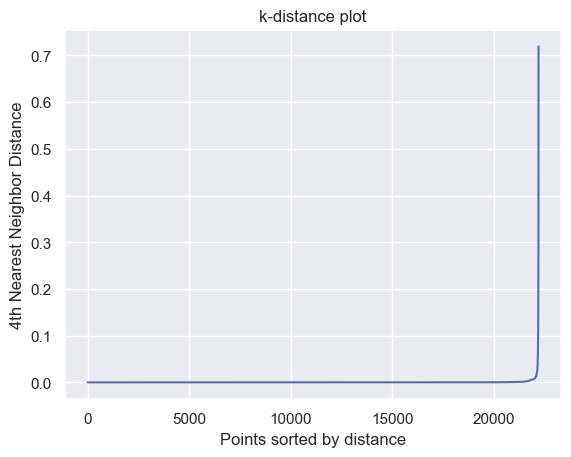

In [27]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(encoded_data)
distances, indices = neighbors_fit.kneighbors(encoded_data)
distances = np.sort(distances[:, 3])
plt.plot(distances)
plt.title("k-distance plot")
plt.xlabel("Points sorted by distance")
plt.ylabel("4th Nearest Neighbor Distance")
plt.show()


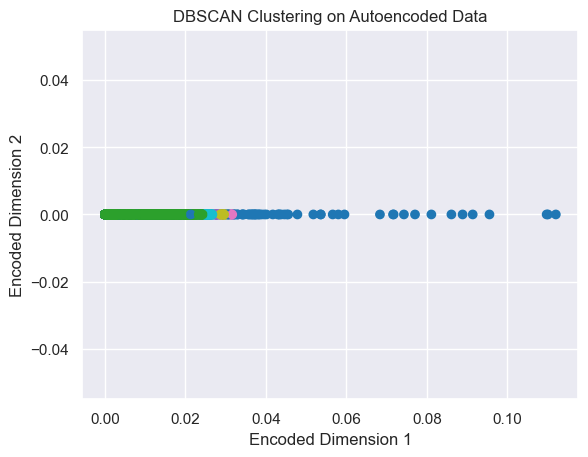

Estimated number of clusters: 5
Estimated number of noise points: 124
Silhouette Score: 0.792


In [28]:

# Run DBSCAN
dbscan = DBSCAN(eps=0.012, min_samples=5)
dbscan_labels = dbscan.fit_predict(encoded_data)

# Visualize results
plt.scatter(encoded_data[:, 0], encoded_data[:, 1], c=dbscan_labels, cmap='tab10')
plt.title('DBSCAN Clustering on Autoencoded Data')
plt.xlabel('Encoded Dimension 1')
plt.ylabel('Encoded Dimension 2')
plt.show()

# Evaluate clustering (only if at least 2 clusters exist)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"Estimated number of clusters: {n_clusters}")
print('Estimated number of noise points: %d' % n_noise)

if n_clusters > 1:
    sil_score = silhouette_score(encoded_data, dbscan_labels)
    print(f"Silhouette Score: {sil_score:.3f}")
else:
    print("Not enough clusters for Silhouette Score.")
    